## Importations

In [98]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import cv2


## Chargement des données

In [49]:
# Chargement des datasets
IMG_SIZE = (48, 48)  # Taille standard 
BATCH_SIZE = 32
COLOR_MODE = 'grayscale'  # Émotions = expressions, pas couleurs



In [50]:
# Chargement du dataset d'entraînement
train_ds = image_dataset_from_directory(
    '../data/train',
    image_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # One-hot encoding pour 7 classes
    shuffle=True,
    seed=123
)

Found 28709 files belonging to 7 classes.


In [51]:
# Chargement du dataset de test
test_ds = image_dataset_from_directory(
    '../data/test',
    image_size=IMG_SIZE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False  # Pas de shuffle pour évaluation
)



Found 7178 files belonging to 7 classes.


In [52]:
# Récupérer les noms des classes
class_names = train_ds.class_names
print("Classes détectées:", class_names)

Classes détectées: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


## Vérification visuelle (Exploration)

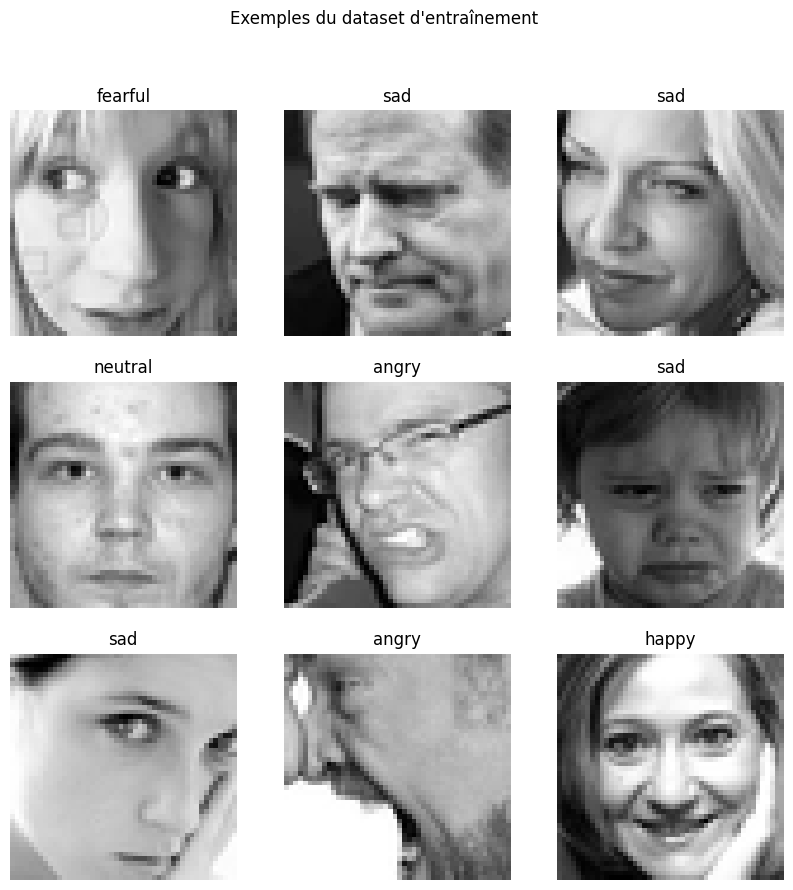

In [53]:
# Afficher 9 exemples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Exemples du dataset d'entraînement")
plt.show()

In [54]:
# Normalisation : pixels de 0-255 → 0-1
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Modèle CNN

In [55]:
#  Architecture CNN
model = tf.keras.Sequential([
    # Input implicite via input_shape
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Anti-overfitting
    layers.Dense(7, activation='softmax')  # 7 émotions
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compilation

In [56]:
# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Entraînement

In [57]:
# Entraînement
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.2639 - loss: 1.9351 - val_accuracy: 0.3575 - val_loss: 1.6631
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.3689 - loss: 1.6218 - val_accuracy: 0.4025 - val_loss: 1.5471
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.4139 - loss: 1.5181 - val_accuracy: 0.4581 - val_loss: 1.4232
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4346 - loss: 1.4598 - val_accuracy: 0.4678 - val_loss: 1.3911
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.4607 - loss: 1.4047 - val_accuracy: 0.4804 - val_loss: 1.3557
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 51s 56ms/step - accuracy: 0.4730 - loss: 1.3760 - val_accuracy: 0.4772 - val_loss: 1.3646
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4915 - loss: 1.3323 - val_accuracy: 0.4939 - val_loss: 1.3377
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.4998 - loss: 1.3014 - 

## Visualisation des résultats

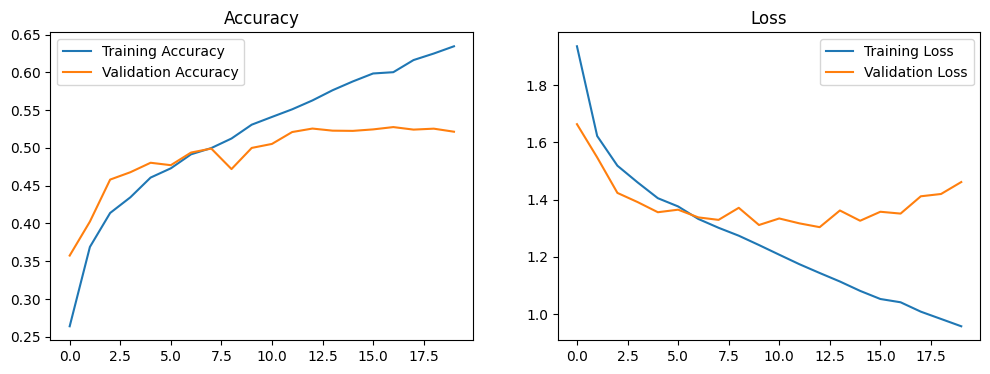

In [58]:
# Courbes d'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')


plt.show()

In [ ]:
evaluate=model.evaluate(test_ds)
print(f"Test Loss: {evaluate[0]:.4f}, Test Accuracy: {evaluate[1]:.4f}")

## Sauvegarde du modèle

In [59]:
# Sauvegarde
model.save('../models/emotion_model.h5')
print("Modèle sauvegardé dans models/emotion_model.h5")

Modèle sauvegardé dans models/emotion_model.h5


## DÉTECTION FACIALE

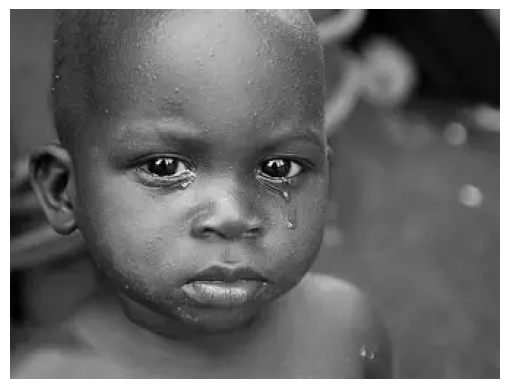

In [2]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('../test_image.jpg')

# Convertir BGR -> RGB (important)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()
